# Post processing for toy 1-min functions

In [15]:
from datetime import datetime
import os

import numpy as np
import pandas as pd
from scipy.stats import qmc
from scipy.optimize import minimize

import torch

import scienceplots

import matplotlib.pyplot as plt
import matplotlib as mp
plt.style.use(['science', 'notebook', 'grid'])

# Then set custom font configurations
FONTSIZE = 20
font = {
    'family': 'serif',
    'weight': 'normal',
    'size': FONTSIZE
}
mp.rc('font', **font)

# Additional configurations
# plt.rcParams['lines.linewidth'] = 5
mp.rc('text', usetex=False)


# set usetex = False if LaTex is not
# available on your system or if the
# rendering is too slow
mp.rc('text', usetex=False)

import gpytorch
from gpytorch.means import ConstantMean
from gpytorch.kernels import ScaleKernel, RBFKernel
from gpytorch.distributions import MultivariateNormal

#`source /cvmfs/sft.cern.ch/lcg/views/LCG_102/x86_64-centos7-gcc11-opt/setup.sh`
from glob import glob
from tqdm import tqdm

import importlib


import configs
importlib.reload(configs)
from configs import *
import acquisition_funcs
importlib.reload(acquisition_funcs)
from acquisition_funcs import *
from objective_funcs import toy_objective_func_one_min
from objective_funcs import toy_objective_func_three_min

import BayesOpt_utils
importlib.reload(BayesOpt_utils)
from BayesOpt_utils import *



In [16]:

PARAM_DICT = {
        'StringZ:aLund' : [0, 2.0],
        'StringZ:bLund': [0, 2.0],
        # 'StringZ:rFactC':[0.0, 2.0],
        # 'StringZ:rFactB': [0., 2.0],
        # 'StringZ:aExtraSQuark':[0.,2.],
        # 'StringZ:aExtraDiquark':[0.,2.],
        # 'StringPT:sigma':[0.,1.],
        # 'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,10.0],
        'StringFlav:ProbStoUD':[0,1.0],
        'StringFlav:probQQtoQ':[0,1.0],
        # 'StringFlav:probSQtoQQ':[0,1.0],
        # 'StringFlav:ProbQQ1toQQ0':[0,1.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]
}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    # "rFactC": 1.32,
    # "rFactB":0.855,
    # "aExtraSQuark": 0.0,
    # "aExtraDiquark":0.97,
    # "sigma":0.335,
    # "enhancedFraction":0.01,
    # "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    # "probSQtoQQ":0.915,
    # "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}


labels_dict = {
    'Adam_restarts_clip_bounds': 'Adam-R',
    'Adam_no_clip_bounds': 'Adam-NR',
    'scipy': 'SLSQP'
}
param_names = list(PARAM_DICT.keys())
num_params = len(param_names)
POINT2 = {key:0.5*value for key, value in MONASH_DICT.items()}
POINT3 = {key:1.5*value for key, value in MONASH_DICT.items()}

NUM_PYTHIA_EVENTS=250000
#250000, 1000
KERNEL = 'Matern'
NUM_TRAIN_POINTS=25
N_TRAIN_EPOCHS=100
N_BO_ITERATIONS = 2# num_params * 30
N_OPTIMIZE_ACQ_ITER = 50
N_RESTARTS = 25
# OPTIMIZE_ACQ_METHOD: ['GD', 'Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']
OPTIMIZE_ACQ_METHOD = 'Adam_restarts_clip_bounds'
KAPPA=-1E-5

num_params=6
	 0      2.953060
1      5.678179
2      9.498348
3     12.447786
4     13.644280
5     15.473382
6     18.998411
7     20.373185
8     23.222052
9     26.612854
10    28.671862
11    30.162532
12    35.307626
13    41.387029
14    43.373183
15    44.591674
16    48.333662
17    50.389714
18    57.294539
19    60.343933
20    63.547453
21    64.750126
22    70.155306
23    73.028034
24    75.836255
25    76.895597
26    78.298049
27    80.157782
28    82.152948
29    85.978860
30    86.073498
31    86.706280
32    87.115024
33    87.283786
34    88.616648
35    88.732695
36    89.295897
37    89.403536
38    90.009651
39    90.062204
40    90.128307
41    90.437195
42    90.539433
43    90.772587
44    90.880318
45    90.934192
46    91.029807
47    91.459415
48    91.780670
49    91.992429
50    92.089781
51    92.297232
52    92.432514
53    92.561067
54    92.719465
Name: chi2, dtype: float64
	 0       2.219935
1       5.204659
2       6.684555
3       9.110727
4       

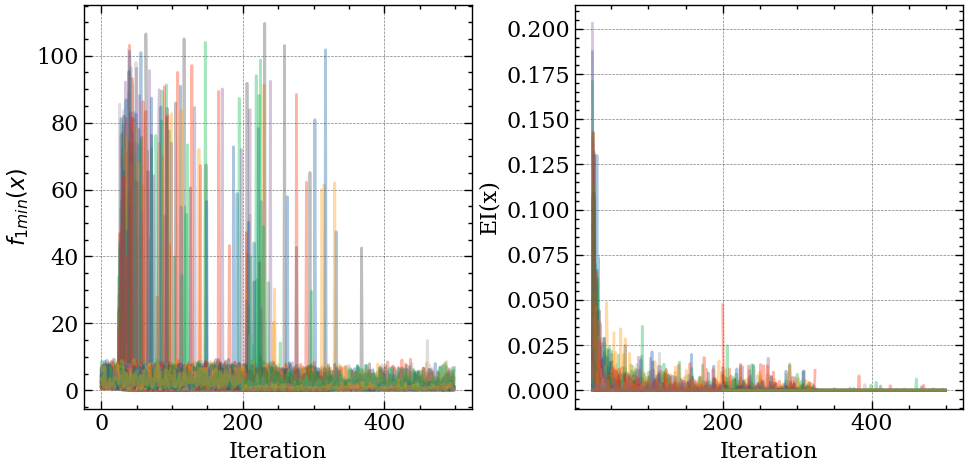

In [4]:
object_func = toy_objective_func_one_min

param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
print(f'num_params={num_params}')

num_train_points_l = [25, 200] #[1]#
n_bo_iterations_l = [30, 100, 300]
n_optimize_acq_iter_l = [10, 50, 100]
n_restarts_l = [5, 25]
optimize_acq_method_l = ['Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']

fig, ax = plt.subplots(1,2,figsize=(10,5))

for num_train_points in num_train_points_l:
    for n_bo_iterations in n_bo_iterations_l:
        for n_optimize_acq_iter in n_optimize_acq_iter_l:   
            for n_restarts in n_restarts_l:
                for optimize_acq_method in optimize_acq_method_l:

                    hyper_params_dict = {
                    'N_BO_ITERATIONS': n_bo_iterations,
                    'N_TRAIN_POINTS': num_train_points,
                    'N_PARAMS': num_params,
                    'N_OPTIMIZE_ACQ_ITER': n_optimize_acq_iter,
                    'N_RESTARTS': n_restarts,
                    'KERNEL': KERNEL,
                    'OPTIMIZE_ACQ_METHOD': optimize_acq_method,
                    'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
                    }
                    
                    _, config_string = configs_df(hyper_params_dict)

                    dir_name = directory_name(object_func, hyper_params_dict)
                    # print(f'dir_name={dir_name}')
                    path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
                    # load the results
                    history_df = load_history_df(path_name)
                    iterations = np.arange(len(history_df))
                    # print(history_df['chi2'])
                    cum_regret = history_df['chi2'].cumsum()
                    print('\t', cum_regret)
                    ax[0].plot(iterations, history_df['chi2'], alpha=0.35)

                    ax[0].set_xlabel('Iteration')
                    ax[0].set_ylabel(r'$f_{1min}(x)$')
                    # ax[0].set_title(f'{object_func.__name__}')
                    ax[0].grid(True)

                    ax[1].plot(iterations, history_df['alpha'], alpha=0.35)
                    ax[1].set_xlabel('Iteration')
                    ax[1].set_ylabel(r'EI(x)')
                    # ax[1].set_title(f'EI acquisition function')
                    ax[1].grid(True)

plt.tight_layout()
plt.savefig(os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', 'post_processing', 'f_onemin_all_hyperparams.pdf'))


# cumulative regret

num_params=6
	 0        4.355068
1        9.450107
2       10.137183
3       12.435734
4       17.273530
          ...    
495    643.312863
496    643.364868
497    644.225830
498    645.621111
499    645.730225
Name: chi2, Length: 500, dtype: float64
	 0         2.363779
1         3.758427
2         8.048518
3        10.702095
4        18.210579
          ...     
495    1667.152083
496    1673.850780
497    1675.953219
498    1677.900138
499    1683.791300
Name: chi2, Length: 500, dtype: float64
	 0        3.487229
1        6.959394
2        9.482482
3       10.264873
4       15.552438
          ...    
495    819.890520
496    819.909201
497    820.628084
498    820.646683
499    820.677562
Name: chi2, Length: 500, dtype: float64


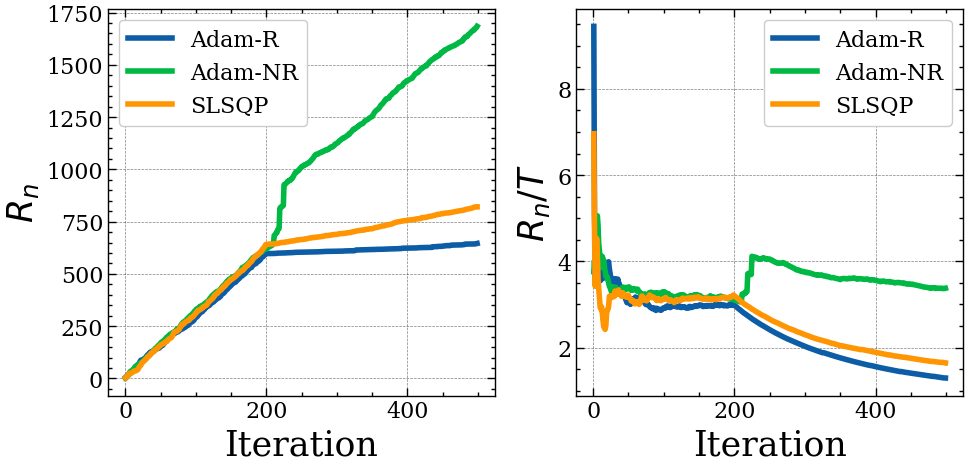

In [5]:
object_func = toy_objective_func_one_min

param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
print(f'num_params={num_params}')

# num_train_points_l = [25, 200] #[1]#
N_TRAIN_POINTS=200
# n_bo_iterations_l = [30, 100, 300]
N_BO_ITERATIONS=300
# n_optimize_acq_iter_l = [10, 50, 100]
N_OPTIMIZE_ACQ_ITER=100
# n_restarts_l = [5, 25]
N_RESTARTS=25
optimize_acq_method_l = ['Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']

fig, ax = plt.subplots(1,2,figsize=(10,5))

for optimize_acq_method in optimize_acq_method_l:

        hyper_params_dict = {
        'N_BO_ITERATIONS': N_BO_ITERATIONS,
        'N_TRAIN_POINTS': N_TRAIN_POINTS,
        'N_PARAMS': num_params,
        'N_OPTIMIZE_ACQ_ITER': n_optimize_acq_iter,
        'N_RESTARTS': N_RESTARTS,
        'KERNEL': KERNEL,
        'OPTIMIZE_ACQ_METHOD': optimize_acq_method,
        'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
        }
        
        _, config_string = configs_df(hyper_params_dict)

        dir_name = directory_name(object_func, hyper_params_dict)
        # print(f'dir_name={dir_name}')
        path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
        # load the results
        history_df = load_history_df(path_name)
        iterations = np.arange(len(history_df))
        # print(history_df['chi2'].head())
        
        cum_regret = (history_df['chi2']).cumsum()
        cum_regret_T = cum_regret / iterations
        print('\t', cum_regret)
        ax[0].plot(iterations, cum_regret, label=labels_dict[optimize_acq_method], linewidth=4)

        ax[0].set_xlabel('Iteration', fontsize=25)
        ax[0].set_ylabel(r'$R_n$', fontsize=25)
        # ax[0].set_title(f'{object_func.__name__}')
        ax[0].grid(True)

        ax[1].plot(iterations, cum_regret_T, label=labels_dict[optimize_acq_method], linewidth=4)
        ax[1].set_xlabel('Iteration', fontsize=25)
        ax[1].set_ylabel(r'$R_n/T$', fontsize=25)
        # ax[1].set_title(f'EI acquisition function')
        ax[1].grid(True)
ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', 'post_processing', 'f_onemin_Regret_opt_methods.pdf'))


# The effect of the number of restarts

num_params=6
	 0        6.801256
1        8.535785
2       11.629477
3       13.132968
4       17.414115
          ...    
495    969.283438
496    970.322864
497    971.510881
498    972.528764
499    973.802714
Name: chi2, Length: 500, dtype: float64
	 0        3.487229
1        6.959394
2        9.482482
3       10.264873
4       15.552438
          ...    
495    819.890520
496    819.909201
497    820.628084
498    820.646683
499    820.677562
Name: chi2, Length: 500, dtype: float64


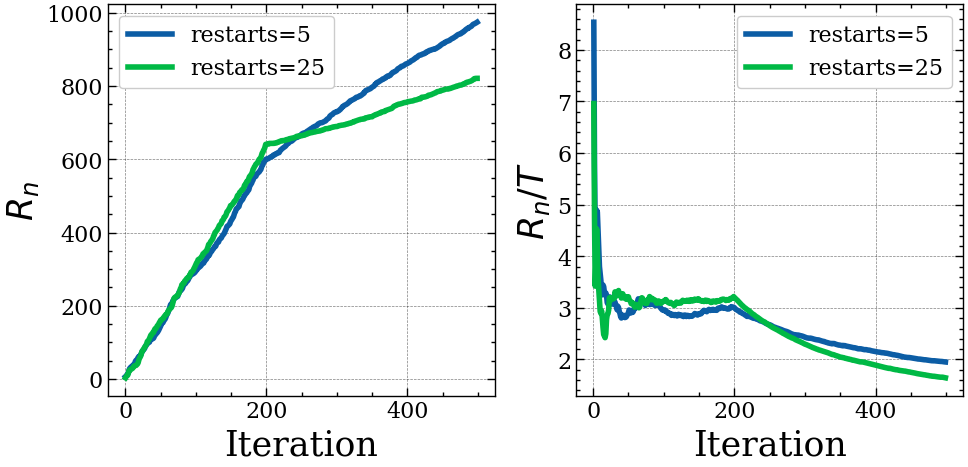

In [6]:
object_func = toy_objective_func_one_min

param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
print(f'num_params={num_params}')

# num_train_points_l = [25, 200] #[1]#
N_TRAIN_POINTS=200
# n_bo_iterations_l = [30, 100, 300]
N_BO_ITERATIONS=300
# n_optimize_acq_iter_l = [10, 50, 100]
N_OPTIMIZE_ACQ_ITER=100
n_restarts_l = [5, 25]
# N_RESTARTS=25
# optimize_acq_method_l = ['Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']
OPTIMIZE_ACQ_METHOD = 'Adam_restarts_clip_bounds'

fig, ax = plt.subplots(1,2,figsize=(10,5))

for n_restarts in n_restarts_l:

        hyper_params_dict = {
        'N_BO_ITERATIONS': N_BO_ITERATIONS,
        'N_TRAIN_POINTS': N_TRAIN_POINTS,
        'N_PARAMS': num_params,
        'N_OPTIMIZE_ACQ_ITER': n_optimize_acq_iter,
        'N_RESTARTS': n_restarts,
        'KERNEL': KERNEL,
        'OPTIMIZE_ACQ_METHOD': optimize_acq_method,
        'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
        }
        
        _, config_string = configs_df(hyper_params_dict)

        dir_name = directory_name(object_func, hyper_params_dict)
        # print(f'dir_name={dir_name}')
        path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
        # load the results
        history_df = load_history_df(path_name)
        iterations = np.arange(len(history_df))
        # print(history_df['chi2'].head())
        
        cum_regret = (history_df['chi2']).cumsum()
        cum_regret_T = cum_regret / iterations
        print('\t', cum_regret)
        ax[0].plot(iterations, cum_regret, label=f'restarts={n_restarts}', linewidth=4)

        ax[0].set_xlabel('Iteration', fontsize=25)
        ax[0].set_ylabel(r'$R_n$', fontsize=25)
        # ax[0].set_title(f'{object_func.__name__}')
        ax[0].grid(True)

        ax[1].plot(iterations, cum_regret_T, label=f'restarts={n_restarts}', linewidth=4)
        ax[1].set_xlabel('Iteration', fontsize=25)
        ax[1].set_ylabel(r'$R_n/T$', fontsize=25)
        # ax[1].set_title(f'EI acquisition function')
        ax[1].grid(True)
ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', 'post_processing', 'f_onemin_Regret_opt_n_restarts.pdf'))


# effect of $\mathcal{D}_{sobol}$

num_params=6
	 25      1.132822
26      2.847492
27      4.010502
28      6.127605
29      7.835382
         ...    
320    74.741468
321    74.894149
322    74.922089
323    74.993116
324    75.096885
Name: chi2, Length: 300, dtype: float64
	 200     0.015755
201     0.120496
202     0.161124
203     0.186244
204     0.224249
         ...    
495    46.157594
496    46.209598
497    47.070561
498    48.465842
499    48.574955
Name: chi2, Length: 300, dtype: float64


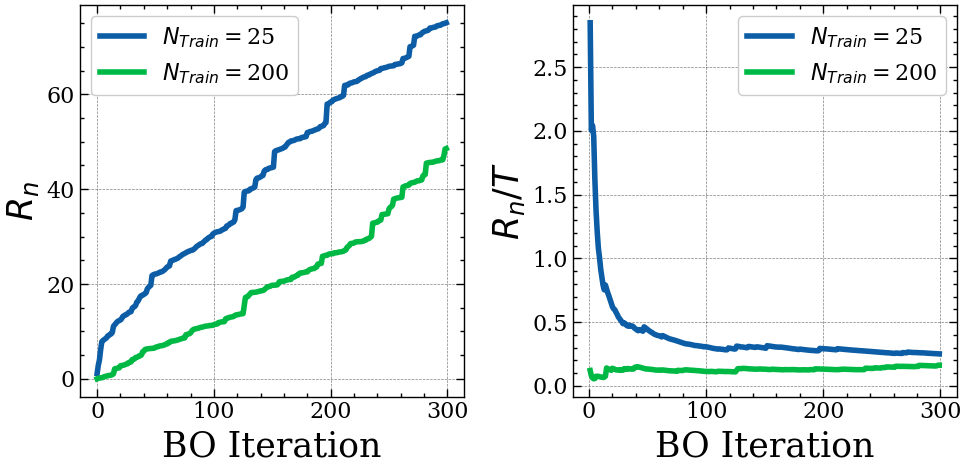

In [9]:
object_func = toy_objective_func_one_min

param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
print(f'num_params={num_params}')

num_train_points_l = [25, 200] #[1]#
# N_TRAIN_POINTS=200
# n_bo_iterations_l = [30, 100, 300]
N_BO_ITERATIONS=300
# n_optimize_acq_iter_l = [10, 50, 100]
N_OPTIMIZE_ACQ_ITER=100
# n_restarts_l = [5, 25]
N_RESTARTS=25
# optimize_acq_method_l = ['Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']
OPTIMIZE_ACQ_METHOD = 'Adam_restarts_clip_bounds'

fig, ax = plt.subplots(1,2,figsize=(10,5))

for num_train_points in num_train_points_l:

        hyper_params_dict = {
        'N_BO_ITERATIONS': N_BO_ITERATIONS,
        'N_TRAIN_POINTS': num_train_points,
        'N_PARAMS': num_params,
        'N_OPTIMIZE_ACQ_ITER': N_OPTIMIZE_ACQ_ITER,
        'N_RESTARTS': N_RESTARTS,
        'KERNEL': KERNEL,
        'OPTIMIZE_ACQ_METHOD': OPTIMIZE_ACQ_METHOD,
        'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
        }
        
        _, config_string = configs_df(hyper_params_dict)

        dir_name = directory_name(object_func, hyper_params_dict)
        # print(f'dir_name={dir_name}')
        path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
        # load the results
        history_df = load_history_df(path_name)
        history_df = history_df[num_train_points:]
        iterations = np.arange(len(history_df))
        # print(history_df['chi2'].head())
        
        cum_regret = (history_df['chi2']).cumsum()
        cum_regret_T = cum_regret / iterations
        print('\t', cum_regret)
        ax[0].plot(iterations, cum_regret, label=r'$N_{Train}=$'+str(num_train_points), linewidth=4)

        ax[0].set_xlabel('BO Iteration', fontsize=25)
        ax[0].set_ylabel(r'$R_n$', fontsize=25)
        # ax[0].set_title(f'{object_func.__name__}')
        ax[0].grid(True)

        ax[1].plot(iterations, cum_regret_T, label=r'$N_{Train}=$'+str(num_train_points), linewidth=4)
        ax[1].set_xlabel('BO Iteration', fontsize=25)
        ax[1].set_ylabel(r'$R_n/T$', fontsize=25)
        # ax[1].set_title(f'EI acquisition function')
        ax[1].grid(True)
ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', 'post_processing', 'f_onemin_Regret_opt_d_sobol.pdf'))


# more dense exploration of dependence of $\mathcal{D}_{sobol}$

num_params=2
N_BO_ITERATIONS_400_N_TRAIN_POINTS_1_N_PARAMS_2_N_OPTIMIZE_ACQ_ITER_50_N_RESTARTS_25_KERNEL_Matern_OPTIMIZE_ACQ_METHOD_Adam_restarts_clip_bounds_NUM_PYTHIA_EVENTS_250000
dir_name=toy_objective_func_one_min_N_BO_ITERATIONS_400_N_TRAIN_POINTS_1_N_PARAMS_2_N_OPTIMIZE_ACQ_ITER_50_N_RESTARTS_25_KERNEL_Matern_OPTIMIZE_ACQ_METHOD_Adam_restarts_clip_bounds_NUM_PYTHIA_EVENTS_250000
	 0       0.730317
1       2.509845
2       4.517877
3       4.980279
4       6.141961
         ...    
396    20.285004
397    20.307120
398    20.449805
399    20.457518
400    20.464714
Name: chi2, Length: 401, dtype: float64
N_BO_ITERATIONS_400_N_TRAIN_POINTS_2_N_PARAMS_2_N_OPTIMIZE_ACQ_ITER_50_N_RESTARTS_25_KERNEL_Matern_OPTIMIZE_ACQ_METHOD_Adam_restarts_clip_bounds_NUM_PYTHIA_EVENTS_250000
dir_name=toy_objective_func_one_min_N_BO_ITERATIONS_400_N_TRAIN_POINTS_2_N_PARAMS_2_N_OPTIMIZE_ACQ_ITER_50_N_RESTARTS_25_KERNEL_Matern_OPTIMIZE_ACQ_METHOD_Adam_restarts_clip_bounds_NUM_PYTHIA_EVENTS_250000
	 0   

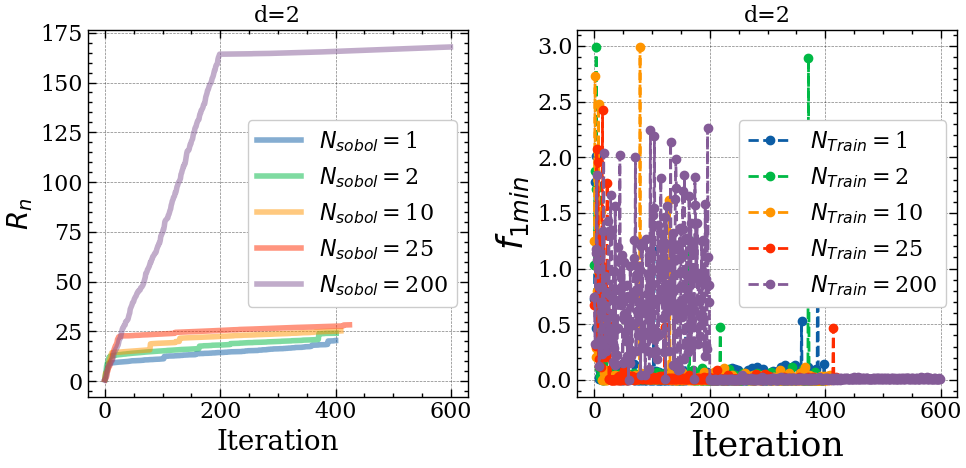

In [17]:
object_func = toy_objective_func_one_min

param_names = list(PARAM_DICT.keys())
# num_params =len(PARAM_DICT)
num_params=2
print(f'num_params={num_params}')
NUM_PYTHIA_EVENTS=250000
# NUM_PYTHIA_EVENTS=1000
#250000, 1000
KERNEL = 'Matern'
num_train_points_l = [1, 2, 10, 25, 200]
N_TRAIN_EPOCHS=25
N_BO_ITERATIONS = 400# num_params * 30
#N_BO_ITERATIONS = 2
N_OPTIMIZE_ACQ_ITER = 50
N_RESTARTS = 25
# OPTIMIZE_ACQ_METHOD: ['GD', 'Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']
OPTIMIZE_ACQ_METHOD = 'Adam_restarts_clip_bounds'
KAPPA=-1E-5

fig, ax = plt.subplots(1,2,figsize=(10,5))

for num_train_points in num_train_points_l:
        # Clear any previous hyper_params_dict
        
        del hyper_params_dict
        hyper_params_dict = {
        'N_BO_ITERATIONS': N_BO_ITERATIONS,
        'N_TRAIN_POINTS': num_train_points,
        'N_PARAMS': 2,
        'N_OPTIMIZE_ACQ_ITER': N_OPTIMIZE_ACQ_ITER,
        'N_RESTARTS': N_RESTARTS,
        'KERNEL': KERNEL,
        'OPTIMIZE_ACQ_METHOD': OPTIMIZE_ACQ_METHOD,
        'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
        }
        
        _, config_string = configs_df(params=hyper_params_dict)
        print(config_string)
        dir_name = directory_name(object_func, hyper_params_dict)
        print(f'dir_name={dir_name}')
        path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
        # load the results
        history_df = load_history_df(path_name)
        history_df = history_df[num_train_points:]
        iterations = np.arange(len(history_df))
        # print(history_df['chi2'].head())
        
        cum_regret = (history_df['chi2']).cumsum()
        cum_regret_T = cum_regret / iterations
        print('\t', cum_regret)
        ax[0].plot(iterations, cum_regret, label=r'$N_{sobol}=$'+str(num_train_points), linewidth=4, alpha=0.5)

        ax[0].set_xlabel('BO Iteration', fontsize=20)
        ax[0].set_ylabel(r'$R_n$', fontsize=20)
        ax[0].set_title(f'd={num_params}')
        ax[0].grid(True)

        ax[1].plot(iterations,history_df['chi2'] , 'o--',label=r'$N_{Train}=$'+str(num_train_points), linewidth=2)
        ax[1].set_xlabel('BO Iteration', fontsize=25)
        ax[1].set_ylabel(r'$f_{1min}$', fontsize=25)
        ax[1].set_title(f'd={num_params}')
        # ax[1].set_title(f'EI acquisition function')
        ax[1].grid(True)
ax[0].legend()
ax[1].legend()

plt.tight_layout()
# plt.savefig(os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', 'post_processing', 'f_onemin_Regret_opt_d_sobol.pdf'))


# absolute error = $f_{best}$ vs $N_{BO}$

num_params=6
{'N_BO_ITERATIONS': 30, 'N_TRAIN_POINTS': 25, 'N_PARAMS': 6, 'N_OPTIMIZE_ACQ_ITER': 100, 'N_RESTARTS': 25, 'KERNEL': 'Matern', 'OPTIMIZE_ACQ_METHOD': 'Adam_restarts_clip_bounds', 'NUM_PYTHIA_EVENTS': 250000}
N_BO_ITERATIONS_30_N_TRAIN_POINTS_25_N_PARAMS_6_N_OPTIMIZE_ACQ_ITER_100_N_RESTARTS_25_KERNEL_Matern_OPTIMIZE_ACQ_METHOD_Adam_restarts_clip_bounds_NUM_PYTHIA_EVENTS_250000
      aLund     bLund  ProbStoUD  probQQtoQ  alphaSvalue     pTmin    best_f
0  0.442157  1.096598        0.0   0.211955         0.25  0.263212  1.320608
{'N_BO_ITERATIONS': 100, 'N_TRAIN_POINTS': 25, 'N_PARAMS': 6, 'N_OPTIMIZE_ACQ_ITER': 100, 'N_RESTARTS': 25, 'KERNEL': 'Matern', 'OPTIMIZE_ACQ_METHOD': 'Adam_restarts_clip_bounds', 'NUM_PYTHIA_EVENTS': 250000}
N_BO_ITERATIONS_100_N_TRAIN_POINTS_25_N_PARAMS_6_N_OPTIMIZE_ACQ_ITER_100_N_RESTARTS_25_KERNEL_Matern_OPTIMIZE_ACQ_METHOD_Adam_restarts_clip_bounds_NUM_PYTHIA_EVENTS_250000
      aLund     bLund  ProbStoUD  probQQtoQ  alphaSvalue     pTmin    bes

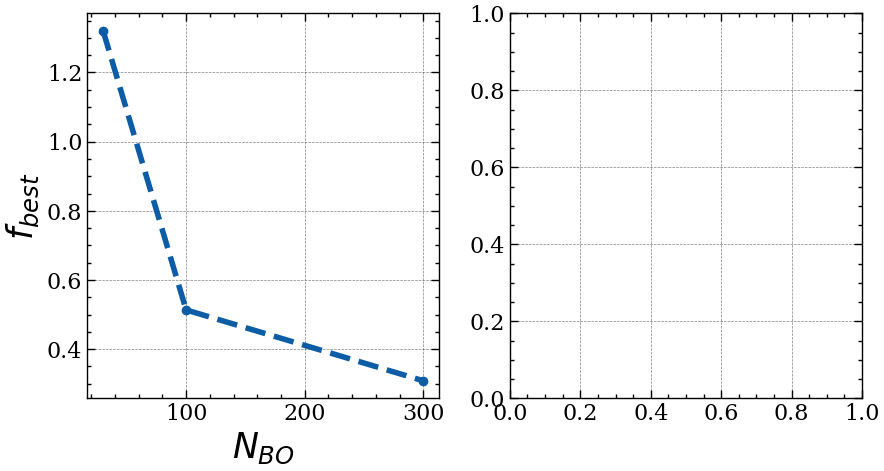

In [10]:
object_func = toy_objective_func_three_min

PARAM_DICT = {
        'StringZ:aLund' : [0, 2.0],
        'StringZ:bLund': [0, 2.0],
        # 'StringZ:rFactC':[0.0, 2.0],
        # 'StringZ:rFactB': [0., 2.0],
        # 'StringZ:aExtraSQuark':[0.,2.],
        # 'StringZ:aExtraDiquark':[0.,2.],
        # 'StringPT:sigma':[0.,1.],
        # 'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,10.0],
        'StringFlav:ProbStoUD':[0,1.0],
        'StringFlav:probQQtoQ':[0,1.0],
        # 'StringFlav:probSQtoQQ':[0,1.0],
        # 'StringFlav:ProbQQ1toQQ0':[0,1.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]
}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    # "rFactC": 1.32,
    # "rFactB":0.855,
    # "aExtraSQuark": 0.0,
    # "aExtraDiquark":0.97,
    # "sigma":0.335,
    # "enhancedFraction":0.01,
    # "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    # "probSQtoQQ":0.915,
    # "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
num_params=6
print(f'num_params={num_params}')

num_train_points_l = [25, 200] #[1]#
N_TRAIN_POINTS=25
n_bo_iterations_l = [30, 100, 300]
n_optimize_acq_iter_l = [10, 50, 100]
N_OPTIMIZE_ACQ_ITER=100
n_restarts_l = [5, 25]
N_RESTARTS=25
optimize_acq_method_l = ['Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']
OPTIMIZE_ACQ_METHOD = 'Adam_restarts_clip_bounds'

fig, ax = plt.subplots(1,2,figsize=(10,5))

best_f_vals=[]
n_bo_l=[]
for n_bo_iterations in n_bo_iterations_l:

        hyper_params_dict = {
        'N_BO_ITERATIONS': n_bo_iterations,
        'N_TRAIN_POINTS': NUM_TRAIN_POINTS,
        'N_PARAMS': num_params,
        'N_OPTIMIZE_ACQ_ITER': N_OPTIMIZE_ACQ_ITER,
        'N_RESTARTS': N_RESTARTS,
        'KERNEL': KERNEL,
        'OPTIMIZE_ACQ_METHOD': OPTIMIZE_ACQ_METHOD,
        'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
        }
        print(hyper_params_dict)
        n_bo_l.append(n_bo_iterations)
        
        _, config_string = configs_df(params=hyper_params_dict)
        print(config_string)
        dir_name = directory_name(object_func, hyper_params_dict)
        # print(f'dir_name={dir_name}')
        path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
        best_params_df = pd.read_csv(os.path.join(path_name, 'best_params.csv'))
        print(best_params_df)
        best_f=best_params_df['best_f'].iloc[0]
        best_f_vals.append(best_f)

print(best_f_vals)
print(n_bo_l)
ax[0].plot(n_bo_l, best_f_vals, 'o--', linewidth=4)
ax[0].set_xlabel('$N_{BO}$', fontsize=25)
ax[0].set_ylabel(r'$f_{best}$', fontsize=25)
ax[0].grid(True)


## $f_{best}$ vs $N_{sobol}$

In [ ]:
object_func = toy_objective_func_three_min

PARAM_DICT = {
        'StringZ:aLund' : [0, 2.0],
        'StringZ:bLund': [0, 2.0],
        # 'StringZ:rFactC':[0.0, 2.0],
        # 'StringZ:rFactB': [0., 2.0],
        # 'StringZ:aExtraSQuark':[0.,2.],
        # 'StringZ:aExtraDiquark':[0.,2.],
        # 'StringPT:sigma':[0.,1.],
        # 'StringPT:enhancedFraction':[0.,1.],
        # 'StringPT:enhancedWidth':[1.0,10.0],
        'StringFlav:ProbStoUD':[0,1.0],
        'StringFlav:probQQtoQ':[0,1.0],
        # 'StringFlav:probSQtoQQ':[0,1.0],
        # 'StringFlav:ProbQQ1toQQ0':[0,1.0],
        'TimeShower:alphaSvalue':[0.06,0.25],
        'TimeShower:pTmin':[0.1,2.0]
}

MONASH_DICT = {
    "aLund" : 0.68, 
    "bLund" : 0.98,
    # "rFactC": 1.32,
    # "rFactB":0.855,
    # "aExtraSQuark": 0.0,
    # "aExtraDiquark":0.97,
    # "sigma":0.335,
    # "enhancedFraction":0.01,
    # "enhancedWidth":2.0,
    "ProbStoUD":0.217,
    "probQQtoQ":0.081,
    # "probSQtoQQ":0.915,
    # "ProbQQ1toQQ0": 0.0275,
    "alphaSvalue": 0.1365,
    "pTmin": 0.5
}

param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
num_params=6
print(f'num_params={num_params}')

num_train_points_l = [25, 200] #[1]#
N_TRAIN_POINTS=25
n_bo_iterations_l = [30, 100, 300]
n_optimize_acq_iter_l = [10, 50, 100]
N_OPTIMIZE_ACQ_ITER=100
n_restarts_l = [5, 25]
N_RESTARTS=25
optimize_acq_method_l = ['Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']
OPTIMIZE_ACQ_METHOD = 'Adam_restarts_clip_bounds'

fig, ax = plt.subplots(1,2,figsize=(10,5))

best_f_vals=[]
n_bo_l=[]
for n_bo_iterations in n_bo_iterations_l:

        hyper_params_dict = {
        'N_BO_ITERATIONS': n_bo_iterations,
        'N_TRAIN_POINTS': NUM_TRAIN_POINTS,
        'N_PARAMS': num_params,
        'N_OPTIMIZE_ACQ_ITER': N_OPTIMIZE_ACQ_ITER,
        'N_RESTARTS': N_RESTARTS,
        'KERNEL': KERNEL,
        'OPTIMIZE_ACQ_METHOD': OPTIMIZE_ACQ_METHOD,
        'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
        }
        print(hyper_params_dict)
        n_bo_l.append(n_bo_iterations)
        
        _, config_string = configs_df(params=hyper_params_dict)
        print(config_string)
        dir_name = directory_name(object_func, hyper_params_dict)
        # print(f'dir_name={dir_name}')
        path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
        best_params_df = pd.read_csv(os.path.join(path_name, 'best_params.csv'))
        print(best_params_df)
        best_f=best_params_df['best_f'].iloc[0]
        best_f_vals.append(best_f)

print(best_f_vals)
print(n_bo_l)
ax[0].plot(n_bo_l, best_f_vals, 'o--', linewidth=4)
ax[0].set_xlabel('$N_{BO}$', fontsize=25)
ax[0].set_ylabel(r'$f_{best}$', fontsize=25)
ax[0].grid(True)


# The effect of number of epochs in optimizing the acquisition function

num_params=6
N_BO_ITERATIONS_300_N_TRAIN_POINTS_25_N_PARAMS_6_N_OPTIMIZE_ACQ_ITER_10_N_RESTARTS_25_KERNEL_Matern_OPTIMIZE_ACQ_METHOD_Adam_restarts_clip_bounds_NUM_PYTHIA_EVENTS_250000
	 0        6.501576
1        8.880783
2       10.637209
3       13.940022
4       16.828367
          ...    
320    138.849680
321    138.894175
322    138.917815
323    139.039496
324    139.282820
Name: chi2, Length: 325, dtype: float64
N_BO_ITERATIONS_300_N_TRAIN_POINTS_25_N_PARAMS_6_N_OPTIMIZE_ACQ_ITER_50_N_RESTARTS_25_KERNEL_Matern_OPTIMIZE_ACQ_METHOD_Adam_restarts_clip_bounds_NUM_PYTHIA_EVENTS_250000
	 0        2.070488
1        2.707071
2       10.066120
3       11.954718
4       14.515892
          ...    
320    149.504126
321    149.592058
322    149.614646
323    149.688578
324    149.760064
Name: chi2, Length: 325, dtype: float64
N_BO_ITERATIONS_300_N_TRAIN_POINTS_25_N_PARAMS_6_N_OPTIMIZE_ACQ_ITER_100_N_RESTARTS_25_KERNEL_Matern_OPTIMIZE_ACQ_METHOD_Adam_restarts_clip_bounds_NUM_PYTHIA_EVENTS_

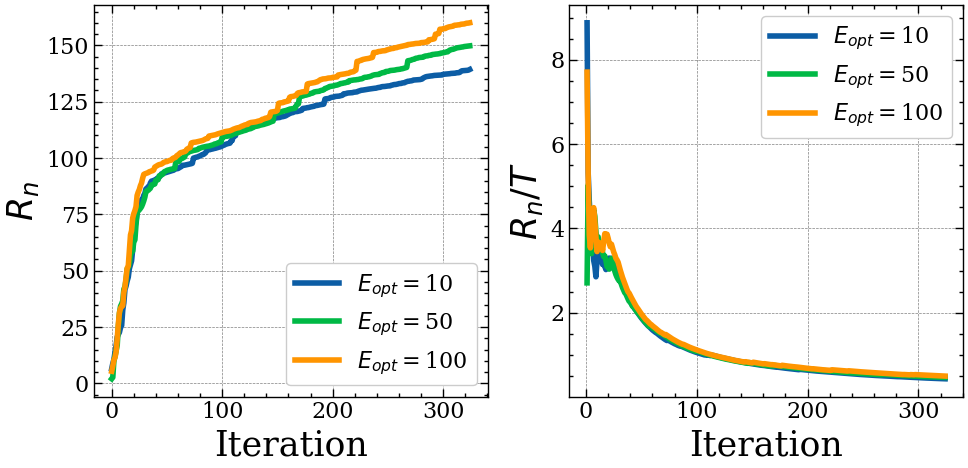

In [68]:
object_func = toy_objective_func_one_min

param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
print(f'num_params={num_params}')

# num_train_points_l = [25, 200] #[1]#
N_TRAIN_POINTS=25
# n_bo_iterations_l = [30, 100, 300]
N_BO_ITERATIONS=300
n_optimize_acq_iter_l = [10, 50, 100]
# N_OPTIMIZE_ACQ_ITER=100
# n_restarts_l = [5, 25]
N_RESTARTS=25
# optimize_acq_method_l = ['Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']
OPTIMIZE_ACQ_METHOD = 'Adam_restarts_clip_bounds'

fig, ax = plt.subplots(1,2,figsize=(10,5))

for n_optimize_acq_iter in n_optimize_acq_iter_l:

        hyper_params_dict = {
        'N_BO_ITERATIONS': N_BO_ITERATIONS,
        'N_TRAIN_POINTS': N_TRAIN_POINTS,
        'N_PARAMS': num_params,
        'N_OPTIMIZE_ACQ_ITER': n_optimize_acq_iter,
        'N_RESTARTS': N_RESTARTS,
        'KERNEL': KERNEL,
        'OPTIMIZE_ACQ_METHOD': OPTIMIZE_ACQ_METHOD,
        'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
        }
        
        _, config_string = configs_df(params=hyper_params_dict)
        print(config_string)
        dir_name = directory_name(object_func, hyper_params_dict)
        # print(f'dir_name={dir_name}')
        path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
        # load the results
        history_df = load_history_df(path_name)
        iterations = np.arange(len(history_df))
        # print(history_df['chi2'].head())
        
        cum_regret = (history_df['chi2']).cumsum()
        cum_regret_T = cum_regret / iterations
        print('\t', cum_regret)
        ax[0].plot(iterations, cum_regret, label=r'$E_{opt}=$'+str(n_optimize_acq_iter), linewidth=4)

        ax[0].set_xlabel('Iteration', fontsize=25)
        ax[0].set_ylabel(r'$R_n$', fontsize=25)
        # ax[0].set_title(f'{object_func.__name__}')
        ax[0].grid(True)

        ax[1].plot(iterations, cum_regret_T, label=r'$E_{opt}=$'+str(n_optimize_acq_iter), linewidth=4)
        ax[1].set_xlabel('Iteration', fontsize=25)
        ax[1].set_ylabel(r'$R_n/T$', fontsize=25)
        # ax[1].set_title(f'EI acquisition function')
        ax[1].grid(True)
ax[0].legend()
ax[1].legend()

plt.tight_layout()
plt.savefig(os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', 'post_processing', 'f_onemin_Regret_opt_E_opt_epochs.pdf'))


## find the configurations for the best $f_{best}$ across all runs

In [54]:
fmin_dir_dict = {}
for num_train_points in num_train_points_l:
    for n_bo_iterations in n_bo_iterations_l:
        for n_optimize_acq_iter in n_optimize_acq_iter_l:   
            for n_restarts in n_restarts_l:
                for optimize_acq_method in optimize_acq_method_l:

                    hyper_params_dict = {
                    'N_BO_ITERATIONS': n_bo_iterations,
                    'N_TRAIN_POINTS': num_train_points,
                    'N_PARAMS': num_params,
                    'N_OPTIMIZE_ACQ_ITER': n_optimize_acq_iter,
                    'N_RESTARTS': n_restarts,
                    'KERNEL': KERNEL,
                    'OPTIMIZE_ACQ_METHOD': optimize_acq_method,
                    'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
                    }
                    
                    _, config_string = configs_df(hyper_params_dict)

                    dir_name = directory_name(object_func, hyper_params_dict)
                    # print(f'dir_name={dir_name}')
                    path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
                    # load the results
                    history_df = load_history_df(path_name)

                    fmin_dir_dict[path_name] = history_df['chi2'].min()




min_key = min(fmin_dir_dict, key=fmin_dir_dict.get)
best_configs_of_all = load_configs_df(min_key)
print(best_configs_of_all)

   N_BO_ITERATIONS  N_TRAIN_POINTS  N_PARAMS  N_OPTIMIZE_ACQ_ITER  N_RESTARTS  \
0              300             200         6                   50           5   

   KERNEL        OPTIMIZE_ACQ_METHOD  NUM_PYTHIA_EVENTS  
0  Matern  Adam_restarts_clip_bounds             250000  


In [55]:
best_configs_of_all['N_OPTIMIZE_ACQ_ITER']

0    50
Name: N_OPTIMIZE_ACQ_ITER, dtype: int64

# See the dependence on optimization method

num_params=6


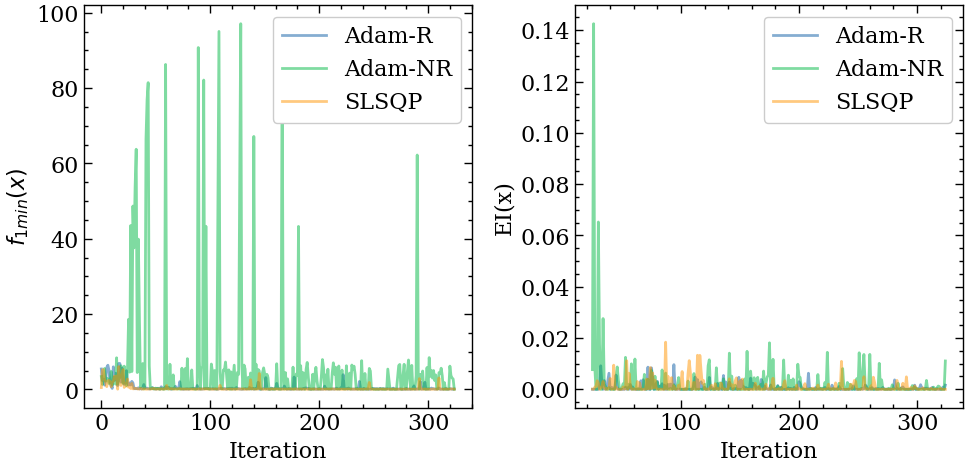

In [56]:
object_func = toy_objective_func_one_min

param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
print(f'num_params={num_params}')

# num_train_points_l = [25, 200] #[1]#
N_TRAIN_POINTS=25
# n_bo_iterations_l = [30, 100, 300]
N_BO_ITERATIONS=300
# n_optimize_acq_iter_l = [10, 50, 100]
N_OPTIMIZE_ACQ_ITER = 100
# n_restarts_l = [5, 25]
N_RESTARTS=25
optimize_acq_method_l = ['Adam_restarts_clip_bounds',
                          'Adam_no_clip_bounds', 
                          'scipy']
# OPTIMIZE_ACQ_METHOD='Adam_no_clip_bounds'
fig, ax = plt.subplots(1,2,figsize=(10,5))


for optimize_acq_method in optimize_acq_method_l:

    hyper_params_dict = {
    'N_BO_ITERATIONS': N_BO_ITERATIONS,
    'N_TRAIN_POINTS': N_TRAIN_POINTS,
    'N_PARAMS': num_params,
    'N_OPTIMIZE_ACQ_ITER': N_OPTIMIZE_ACQ_ITER,
    'N_RESTARTS': N_RESTARTS,
    'KERNEL': KERNEL,
    'OPTIMIZE_ACQ_METHOD': optimize_acq_method,
    'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
    }
    


    dir_name = directory_name(object_func, hyper_params_dict)
    # print(f'dir_name={dir_name}')
    path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
    _, config_string = configs_df(hyper_params_dict)
    # load the results
    history_df = load_history_df(path_name)
    iterations = np.arange(len(history_df))

    ax[0].plot(iterations, history_df['chi2'], alpha=0.5, label=labels_dict[optimize_acq_method])
    ax[0].set_xlabel('Iteration')
    ax[0].set_ylabel(r'$f_{1min}(x)$')
    # ax[0].set_title(f'{object_func.__name__}')

    ax[1].plot(iterations, history_df['alpha'], alpha=0.5, label=labels_dict[optimize_acq_method])
    ax[1].set_xlabel('Iteration')
    ax[1].set_ylabel(r'EI(x)')
    # ax[1].set_title(f'EI acquisition function')



for i in range(2):
    ax[i].grid()
    ax[i].legend()
    # ax[i].annotate(
    # f'restarts={N_RESTARTS}',
    # xy=(0.5, 0.9),  # Adjust these values to position the text
    # xycoords='axes fraction',
    # ha='center',  # Horizontal alignment
    # va='center'   # Vertical alignment
    # )

plt.tight_layout()
plt.savefig(os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', 'post_processing', 'f_onemin_effect_of_opt_method.pdf'))

# make table for 'Adam_restarts_clip_bounds'

In [57]:
object_func = toy_objective_func_one_min

param_names = list(PARAM_DICT.keys())
num_params =len(PARAM_DICT)
print(f'num_params={num_params}')

num_train_points_l = [25, 200] #[1]#
n_bo_iterations_l = [30, 100, 300]
n_optimize_acq_iter_l = [10, 50, 100]
n_restarts_l = [5, 25]
optimize_acq_method_l = ['Adam_restarts_clip_bounds', 'Adam_no_clip_bounds', 'scipy']
OPTIMIZE_ACQ_METHOD = 'Adam_restarts_clip_bounds'

Adam_restarts_clip_bounds_paths = []

for num_train_points in num_train_points_l:
    for n_bo_iterations in n_bo_iterations_l:
        for n_optimize_acq_iter in n_optimize_acq_iter_l:   
            for n_restarts in n_restarts_l:

                hyper_params_dict = {
                'N_BO_ITERATIONS': n_bo_iterations,
                'N_TRAIN_POINTS': num_train_points,
                'N_PARAMS': num_params,
                'N_OPTIMIZE_ACQ_ITER': n_optimize_acq_iter,
                'N_RESTARTS': n_restarts,
                'KERNEL': KERNEL,
                'OPTIMIZE_ACQ_METHOD': OPTIMIZE_ACQ_METHOD,
                'NUM_PYTHIA_EVENTS': NUM_PYTHIA_EVENTS,
                }
                
                _, config_string = configs_df(hyper_params_dict)

                dir_name = directory_name(object_func, hyper_params_dict)
                # print(f'dir_name={dir_name}')
                path_name = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', dir_name)
                Adam_restarts_clip_bounds_paths.append(path_name)


 


num_params=6


In [58]:
# table_df_Adam_restarts_clip_bounds = pd.DataFrame(columns=['x_1','x_2', 'x_3', 'x_4', 'x_5', 'x_6', 'fmin', 'n_train_points', 'n_bo_iterations', 'n_optimize_acq_iter', 'n_restarts'])

table_df_Adam_restarts_clip_bounds = pd.DataFrame(columns=['$x_1$', '$x_2$', '$x_3$', '$x_4$', '$x_5$', '$x_6$', '$f^*$', '$N_{\text{sobol}}$', '$N_\text{BO}$', '$N_\text{optimize}$', '$N_\text{restarts}$'])


df_size = len(num_train_points_l) * len(n_bo_iterations_l) * len(n_optimize_acq_iter_l) * len(n_restarts_l)

data_rows=[]


latex_table_dir = os.path.join(BAYESOPT_BASE, 'BayesOpt', 'output', 'latex_tables')
if not os.path.exists(latex_table_dir):
    os.makedirs(latex_table_dir)
Adam_restarts_clip_bounds_latex_table_name = os.path.join(latex_table_dir, 'Adam_restarts_clip_bounds_table_TOY_ONE_MIN.tex')

for path_name, rowindex in zip(Adam_restarts_clip_bounds_paths, range(df_size)):
    best_params_df = load_best_params_df(path_name)
    history_df = load_history_df(path_name)
    configs_df = load_configs_df(path_name)
    
    row = {
        '$x_1$': round(float(best_params_df['aLund'].iloc[0]), 4),
        '$x_2$': round(float(best_params_df['bLund'].iloc[0]), 4),
        '$x_3$': round(float(best_params_df['ProbStoUD'].iloc[0]), 4),
        '$x_4$': round(float(best_params_df['probQQtoQ'].iloc[0]), 4),
        '$x_5$': round(float(best_params_df['alphaSvalue'].iloc[0]), 4),
        '$x_6$': round(float(best_params_df['pTmin'].iloc[0]), 4),
        '$f^*$': round(float(history_df['chi2'].min()), 4),
        '$N_{\\text{sobol}}$': configs_df['N_TRAIN_POINTS'].iloc[0],
        '$N_\\text{BO}$': configs_df['N_BO_ITERATIONS'].iloc[0],
        '$N_\\text{optimize}$': configs_df['N_OPTIMIZE_ACQ_ITER'].iloc[0],
        '$N_\\text{restarts}$': configs_df['N_RESTARTS'].iloc[0]
    }
    data_rows.append(row)

table_df_Adam_restarts_clip_bounds = pd.DataFrame(data_rows)

In [59]:
table_df_Adam_restarts_clip_bounds

,$x_1$,$x_2$,$x_3$,$x_4$,$x_5$,$x_6$,$f^*$,$N_{\text{sobol}}$,$N_\text{BO}$,$N_\text{optimize}$,$N_\text{restarts}$
0,0.6793,0.9408,0.1394,0.0000,0.2500,0.5401,0.0526,25,30,10,5
1,0.5784,1.0246,0.0708,0.0000,0.0600,0.5429,0.0715,25,30,10,25
2,0.7038,0.9266,0.2685,0.0000,0.2500,0.5368,0.0492,25,30,50,5
3,0.5925,1.0153,0.0478,0.0000,0.0600,0.5765,0.0884,25,30,50,25
4,0.6184,0.8121,0.2505,0.0000,0.2500,0.5390,0.0811,25,30,100,5
5,0.8457,0.9559,0.1247,0.0347,0.2500,0.6154,0.1040,25,30,100,25
6,0.6995,0.9850,0.1788,0.0000,0.0600,0.5172,0.0267,25,100,10,5
7,0.6092,1.0428,0.2668,0.1065,0.0600,0.5410,0.0307,25,100,10,25
8,0.6691,1.0384,0.1597,0.0248,0.0600,0.5448,0.0315,25,100,50,5
9,0.6611,0.9696,0.1913,0.0000,0.0600,0.5827,0.0419,25,100,50,25


In [60]:

latex_table_Adam_restarts_clip_bounds = table_df_Adam_restarts_clip_bounds.to_latex(buf=Adam_restarts_clip_bounds_latex_table_name, index=False,     float_format="%.3f"   
)
print(latex_table_Adam_restarts_clip_bounds)

None
